root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million: 

<ipython-input-1-bcc0e89b9505>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_cases", y="location", data=top_10_cases, palette="Blues_r")


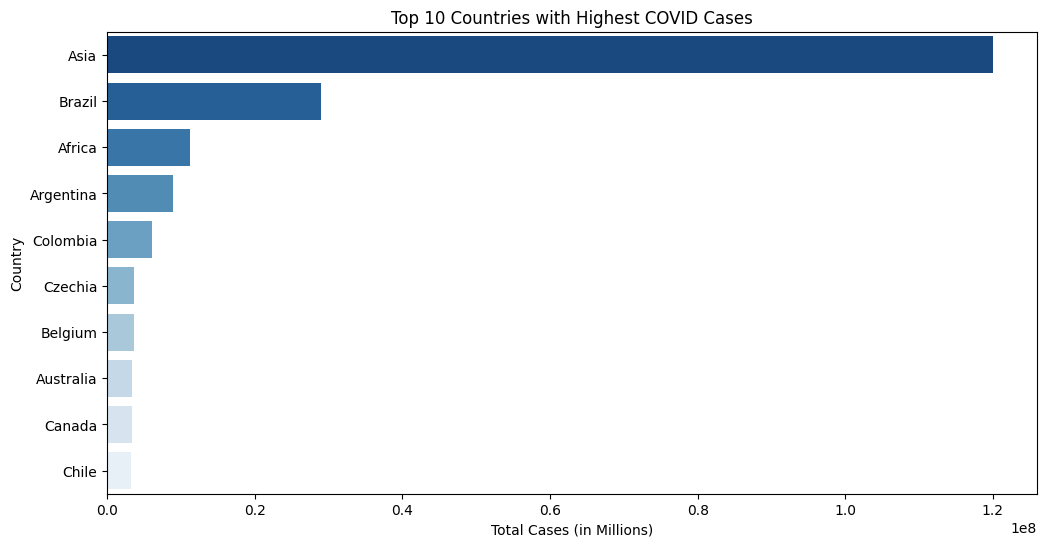

<ipython-input-1-bcc0e89b9505>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_deaths", y="location", data=top_10_deaths, palette="Reds_r")


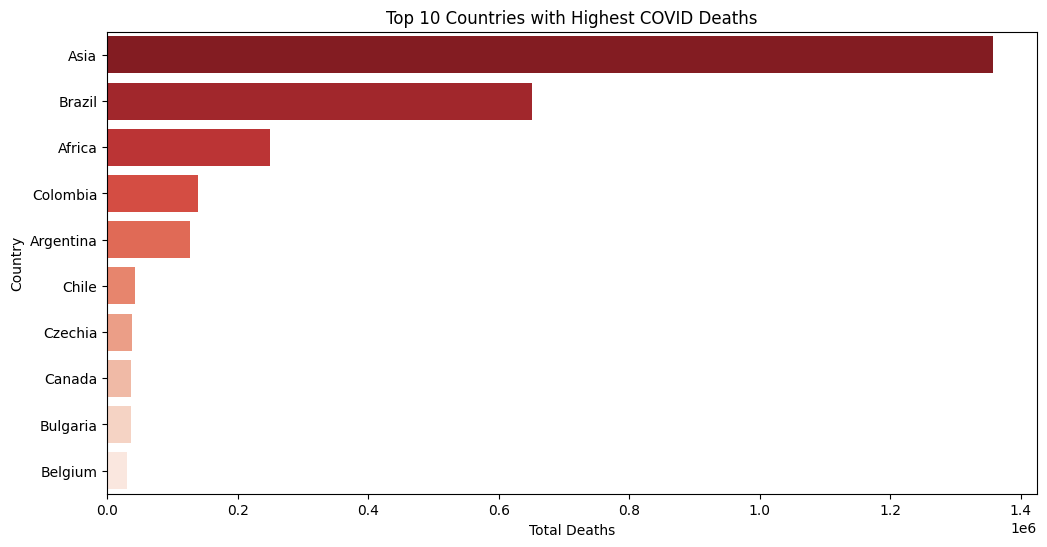

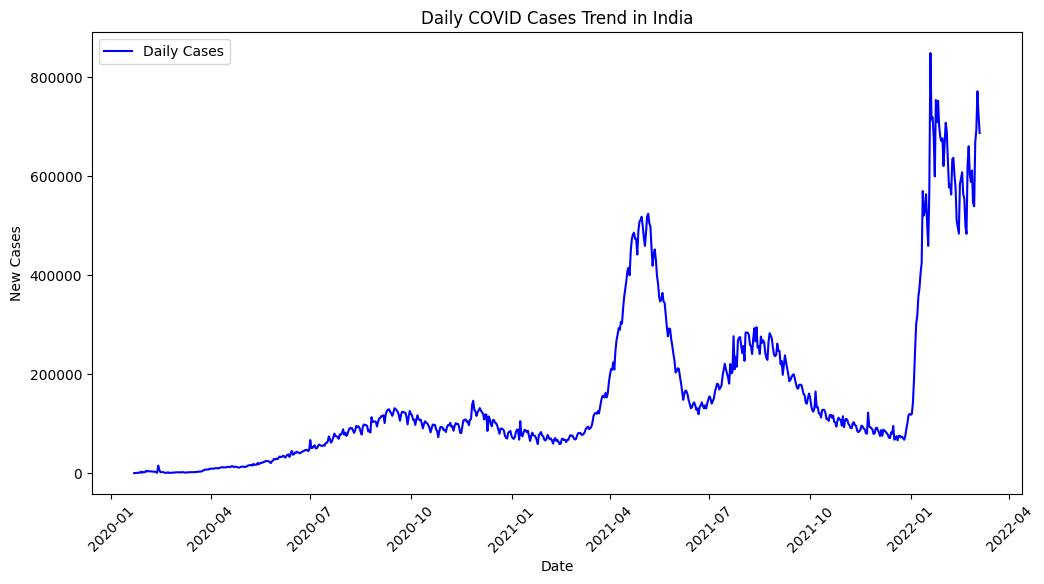

Analysis complete! Data saved.


In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_date

# Initialize Spark Session
spark = SparkSession.builder.appName("COVIDDataAnalysis").getOrCreate()

# Load the dataset
csv_file = "/content/owid-covid-data.csv"
df = spark.read.csv(csv_file, header=True, inferSchema=True)

# Data Exploration
df.printSchema()
print(f"Total Rows: {df.count()}")

# Data Cleaning
df_clean = df.filter(col("new_cases").isNotNull())
df_clean = df_clean.withColumn("date", to_date(col("date")))

# Analysis: Total Cases per Country
df_cases = df_clean.groupBy("location").agg(sum("new_cases").alias("total_cases"))
df_cases_pd = df_cases.toPandas()

# Analysis: Total Deaths per Country
df_deaths = df_clean.groupBy("location").agg(sum("new_deaths").alias("total_deaths"))
df_deaths_pd = df_deaths.toPandas()

# Visualization: Total Cases per Country
top_10_cases = df_cases_pd.sort_values(by="total_cases", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="total_cases", y="location", data=top_10_cases, palette="Blues_r")
plt.xlabel("Total Cases (in Millions)")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest COVID Cases")
plt.show()

# Visualization: Total Deaths per Country
top_10_deaths = df_deaths_pd.sort_values(by="total_deaths", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="total_deaths", y="location", data=top_10_deaths, palette="Reds_r")
plt.xlabel("Total Deaths")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest COVID Deaths")
plt.show()

# Visualization: COVID Cases Over Time for India
df_india = df_clean.filter(df_clean.location == "Asia").select("date", "new_cases").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(df_india["date"], df_india["new_cases"], color='blue', label="Daily Cases")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.title("Daily COVID Cases Trend in India")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Save results
df_cases.write.csv("/content/covid_cases_per_country.csv", header=True)
df_deaths.write.csv("/content/covid_deaths_per_country.csv", header=True)

print("Analysis complete! Data saved.")
